# Individual Variability across cerebellum

In [1]:
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.dataset as ds
import ProbabilisticParcellation.util as ut
from copy import deepcopy
import ProbabilisticParcellation.learn_fusion_gpu as lf
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as sc
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sm
import ProbabilisticParcellation.scripts.atlas_paper.describe_atlas as da
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.evaluation as ev
import Functional_Fusion.atlas_map as am
import SUITPy as suit
import os
import ProbabilisticParcellation.scripts.atlas_paper.individual_variability as var
import nitools as nt
import nibabel as nb


In [2]:
figure_path = "/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts/"
if not os.path.exists(figure_path):
    figure_path = "/Users/callithrix/Dropbox/AtlasPaper/figure_parts/"
atlas_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'


In [3]:
T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")
Data, Info = [], []
for d, dname in enumerate(T.name[:-1]):
    data, info, dset = ds.get_dataset(ut.base_dir, dname, atlas="MNISymC2")
    Data.append(data)
    Info.append(info)

/Users/callithrix/code/Python/Functional_Fusion/dataset.py:467: UserWarning: sub-11, ses-preference, CondHalf - missing data painting_constant-half2
  warnings.warn(


In [4]:
# Get inter-individual variability for plotting
Corr, Corr_norm, Rel = var.calc_variability(Data, Info, subject_wise=False)

/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:173: RuntimeWarning: Mean of empty slice
  correlation = np.nanmean(
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:176: RuntimeWarning: Mean of empty slice
  noise_ceiling = np.nanmean(


In [5]:
# Get inter-individual variability for statistics
Corr_subj, Corr_norm_subj, Rel_subj = var.calc_variability(Data, Info, subject_wise=True)

/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:170: RuntimeWarning: Mean of empty slice
  corr_norm.append(np.nanmean(corr_normalised, axis=0))
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/individual_variability.py:169: RuntimeWarning: Mean of empty slice
  corr.append(np.nanmean(correlation, axis=0))


In [6]:
T = pd.read_csv(ut.base_dir + "/dataset_description.tsv", sep="\t")
cscale = (0,1)
# Get atlas
suit_atlas, _ = am.get_atlas("MNISymC2", ut.base_dir + "/Atlases")

# Plot Variabilities

## MDTB

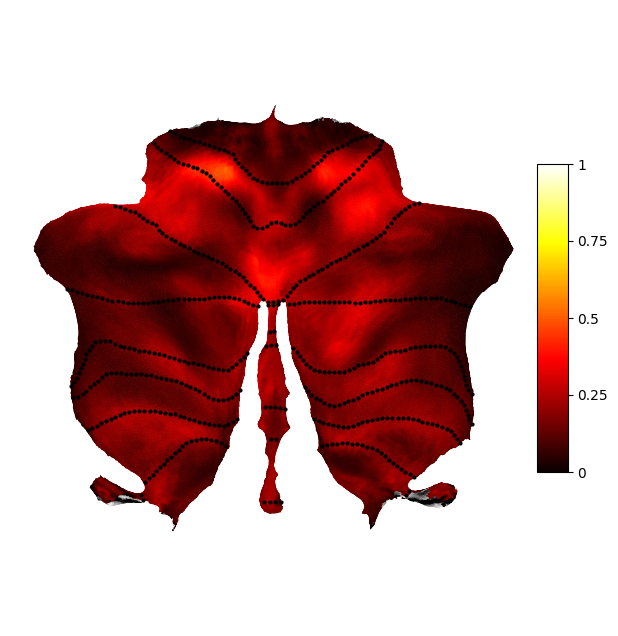

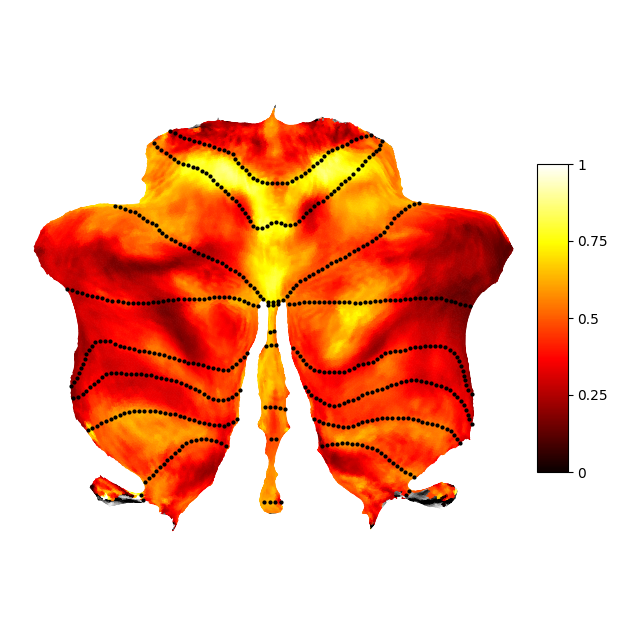

In [7]:
dataset = 'MDTB'
d = np.where([T.name == dataset])[0].item()

# Plot individual variability
Nifti = suit_atlas.data_to_nifti(Corr[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_{dataset}"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")


# Plot normalized individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm[d])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_norm_{dataset}_norm"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")

# Variability for all datasets

<AxesSubplot: title={'center': 'Somatotopic'}>

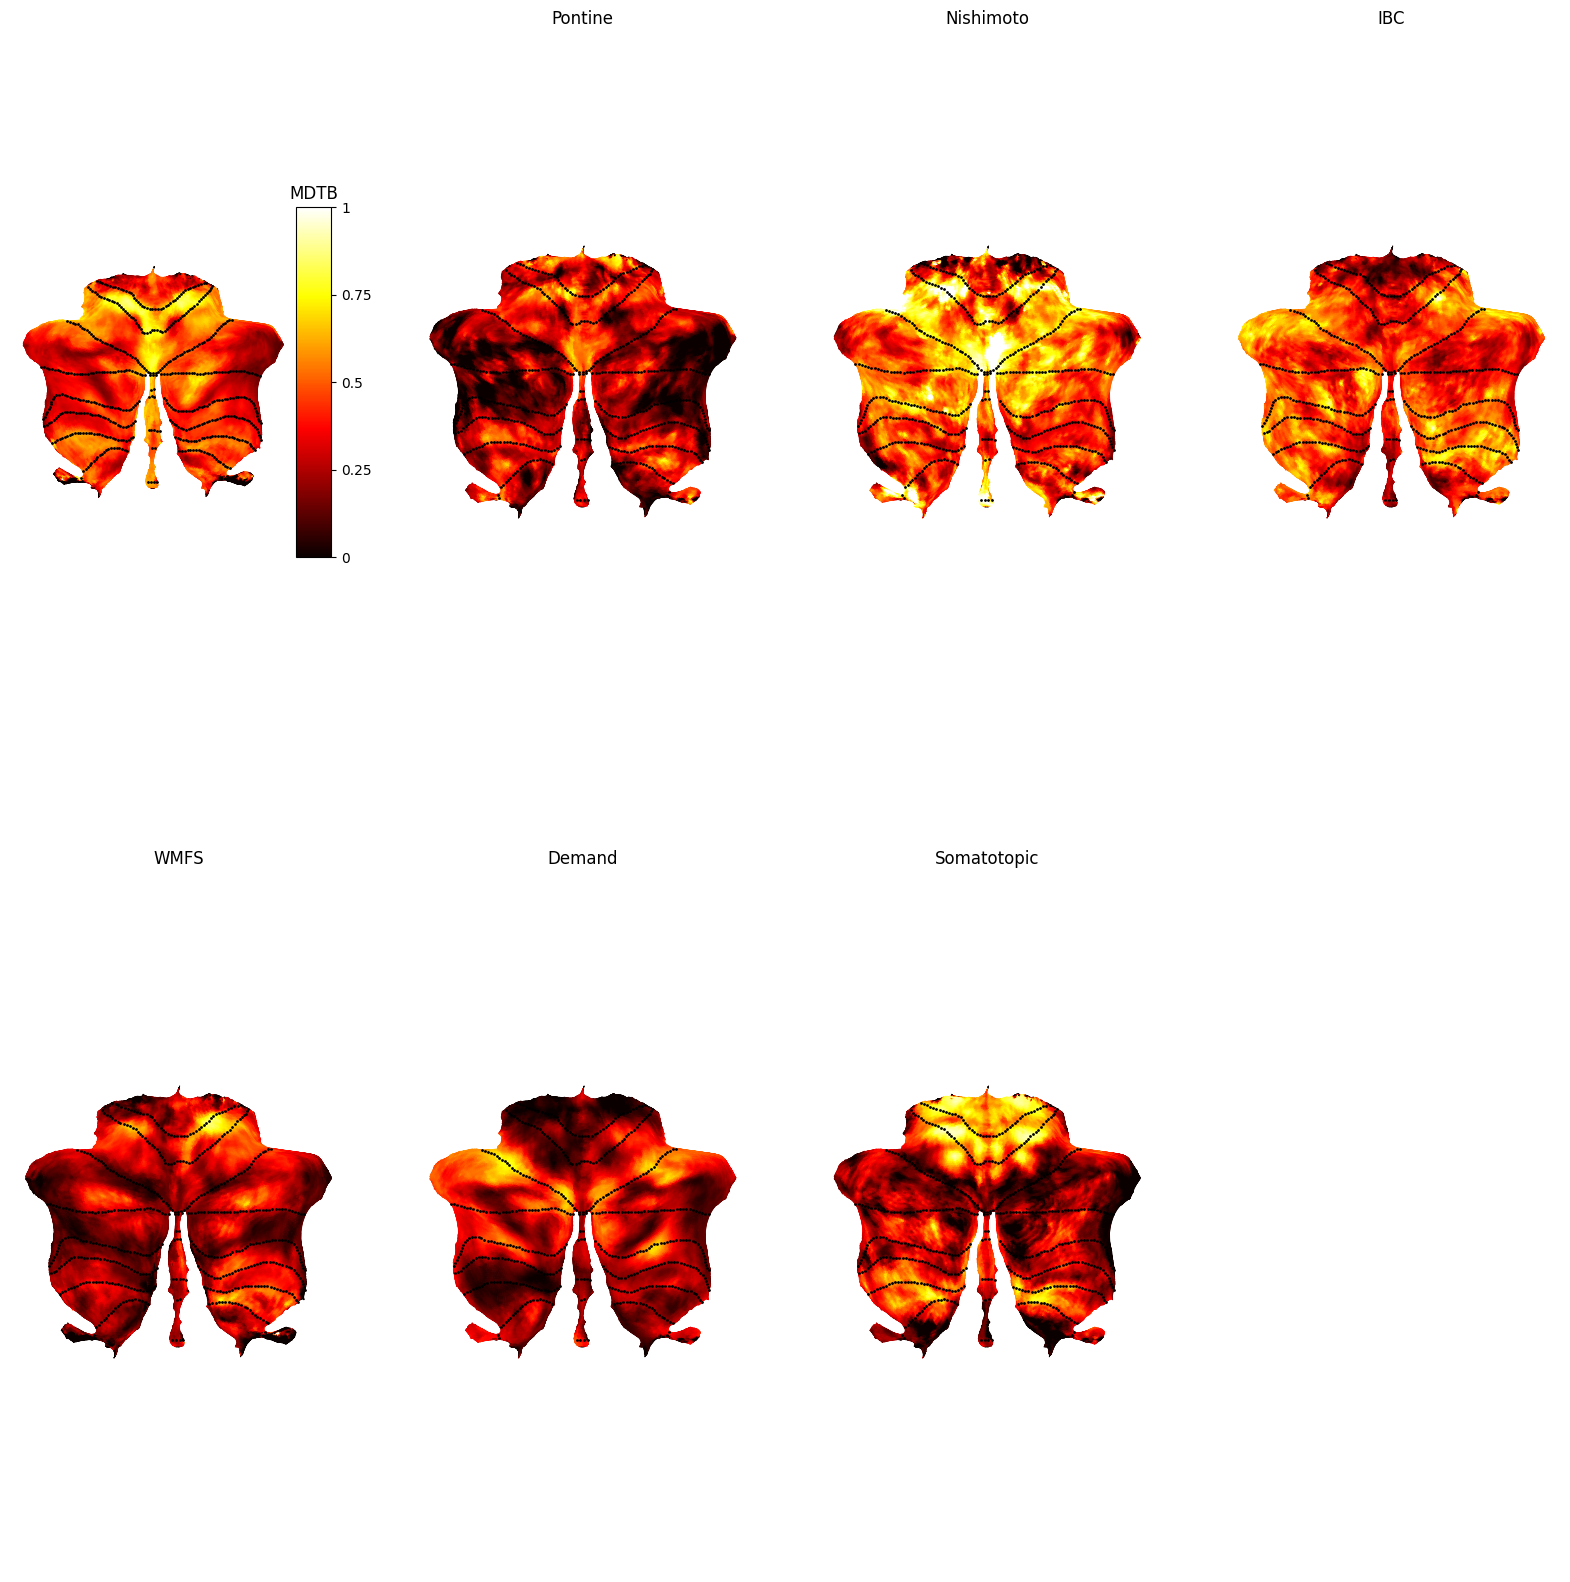

In [14]:
plt.figure(figsize=(20, 20))
ut.plot_multi_flat(Corr_norm, 'MNISymC2',
                   grid=(2, 4),
                   dtype='func',
                   colorbar=True,
                   cmap='hot',
                   cscale=cscale,
                   titles=T.name[:-1].values)

# Average across datasets

In [8]:
# Average Corr_norm values apart fron Nishimoto & IBC
exclude = ['Nishimoto', 'IBC']
Corr_norm_mean = np.nanmean([Corr_norm[i] for i in range(len(Corr_norm)) if T.name[i] not in exclude], axis=0)

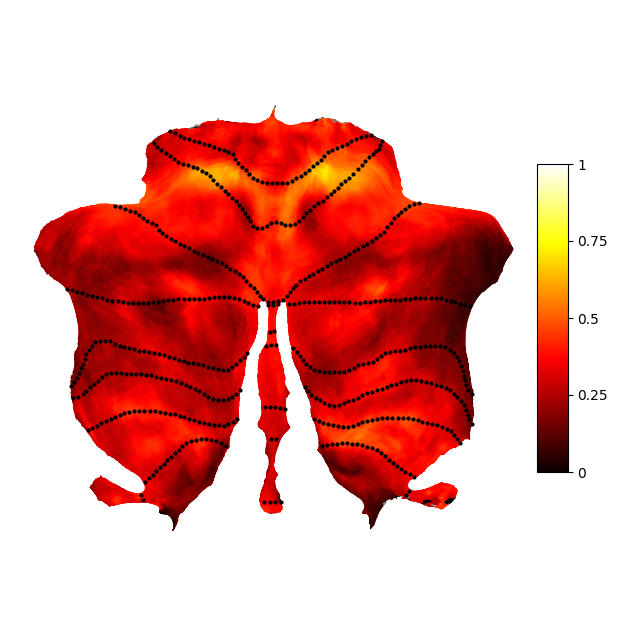

In [9]:
# Plot individual variability
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
figsize = (8, 8)
plt.figure(figsize=figsize)
suit.flatmap.plot(
    surf_data,
    render="matplotlib",
    new_figure=False,
    cmap="hot",
    cscale=cscale,
    overlay_type="func",
    colorbar=True,
    bordersize=4,
)
filename = f"var_all_norm"
plt.savefig(f"{figure_path}/individual_variability/{filename}.png", dpi=300, bbox_inches="tight")


# Stats

In [31]:

mname = 'Models_03/NettekovenSym68_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)

# Get winner take-all
Prob = np.array(model.marginal_prob())
parcel = Prob.argmax(axis=0) + 1



In [32]:
# Map the variability to the parcels   
Nifti = suit_atlas.data_to_nifti(parcel.astype(float))
surf_parcel = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3542792369.py:6: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


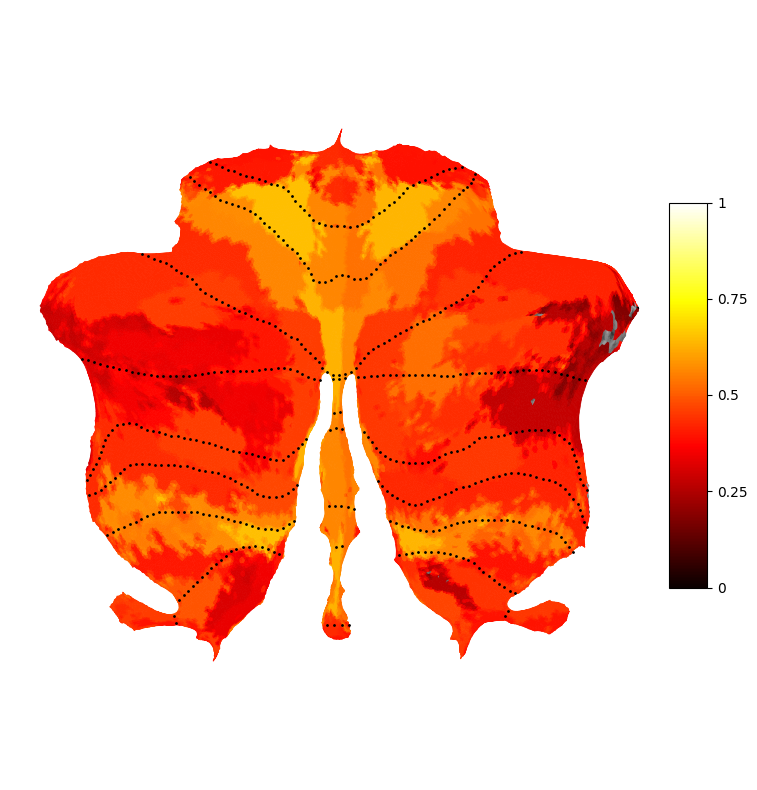

In [34]:
Nifti = suit_atlas.data_to_nifti(Corr_norm[0])
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel.shape) * np.nan
for p in np.arange(0,surf_parcel.max()):
    mask = (surf_parcel == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_68-mdtb.png',
            dpi=300, bbox_inches='tight')


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19187/3797039473.py:6: RuntimeWarning: Mean of empty slice
  corr_map[mask] = np.nanmean(surf_data[mask])


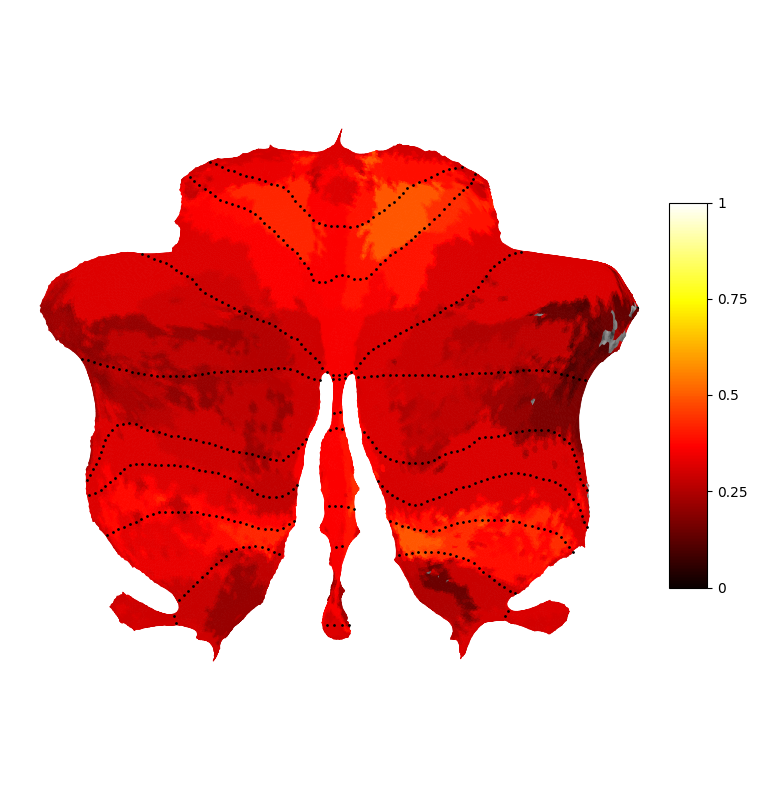

In [35]:
Nifti = suit_atlas.data_to_nifti(Corr_norm_mean)
surf_data = suit.flatmap.vol_to_surf(Nifti, stats="nanmean", space="MNISymC")
corr_map = np.zeros(surf_parcel.shape) * np.nan
for p in np.arange(0,surf_parcel.max()):
    mask = (surf_parcel == p).squeeze()
    corr_map[mask] = np.nanmean(surf_data[mask])


# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(corr_map,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap='hot')
plt.savefig(figure_path + '/individual_variability/var_parcel_norm_68-all.png',
            dpi=300, bbox_inches='tight')
